In [18]:
import numpy as np
import math
import matplotlib.pyplot as plt
import PyMieScatt as ps
import os
import time
from scipy.io import readsav
from scipy import interpolate
from scipy import signal
import scipy.optimize as opt
import PyMieScatt as ps

In [19]:
def wb08read(): 
    f=open('WB08_Iceconstants.csv','r')
    wavew=[]
    nw=[]
    kw=[]
    temp=[]
    #line=line.strip(',')
    #print(line)
    for line in f:
        line = line.strip()
        columns = line.split(',')
        wavew.append(float(columns[0]))
        nw.append(float(columns[1]))
        kw.append(float(columns[2]))
    wavew=np.array(wavew)
    nw=np.array(nw)
    kw=np.array(kw)
    return wavew,nw,kw

def khare84read(): 
    f=open('Khare84constants.txt','r')
    wavew=[]
    nw=[]
    kw=[]
    temp=[]
    #line=line.strip(',')
    #print(line)
    for line in f:
        line = line.strip()
        columns = line.split()
        wavew.append(float(columns[0]))
        nw.append(float(columns[2]))
        kw.append(float(columns[1]))
    wavew=np.array(wavew)
    nw=np.array(nw)
    kw=np.array(kw)
    return wavew,nw,kw

def baratta15read(): 
    f=open('Baratta_2015_CH4-CO-N2_1-1-1_300K_all_rev.csv','r')
    header1=f.readline()
    header2=f.readline()
    header3=f.readline()
    header4=f.readline()
    header5=f.readline()
    header6=f.readline()
    header7=f.readline()
    header8=f.readline()
    header9=f.readline()
    header10=f.readline()
    #header11=f.readline()
    wavew=[]
    nw=[]
    kw=[]
    #line=line.strip(',')
    #print(line)
    for line in f:
        line = line.strip()
        columns = line.split(',')
        wavew.append(float(columns[0]))
        nw.append(float(columns[1]))
        kw.append(float(columns[5]))
    wavew=1e4/np.array(wavew)
    nw=np.array(nw)
    kw=np.array(kw)
    return wavew,nw,kw

In [20]:
def hemaread():
    f=open('Hematite_EXC_constants.txt','r')
    header1=f.readline()
    header2=f.readline()
    header3=f.readline()
    header4=f.readline()
    header5=f.readline()
    header6=f.readline()
    header7=f.readline()
    header8=f.readline()
    header9=f.readline()
    header10=f.readline()
    header11=f.readline()
    wavew=[]
    nw=[]
    kw=[]
    for line in f:
        line = line.strip()
        columns = line.split()
        wavew.append(float(columns[0]))
        nw.append(float(columns[1]))
        kw.append(float(columns[2]))

    wavew=np.array(wavew)
    nw=np.array(nw)
    kw=np.array(kw)
    return wavew,nw,kw

In [22]:
wavex=np.zeros(352)
#datir=readsav('lambda.sav')
#wavey=datir.lambda
datv=readsav('lambdav.sav')

wavex[0:96]=datv.lambdav
wavex[96:352]=np.linspace(.85,5.2,256)
#print(datir)



wavew,nw,kw=wb08read()
wavek,nk,kk=khare84read()
waveb,nb,kb=baratta15read()
waveh,nh,kh=hemaread()
nwfunc=interpolate.interp1d(wavew,nw)
kwfunc=interpolate.interp1d(wavew,kw)
nkfunc=interpolate.interp1d(wavek,nk)
kkfunc=interpolate.interp1d(wavek,kk)
nbfunc=interpolate.interp1d(waveb,nb)
kbfunc=interpolate.interp1d(waveb,kb)
nhfunc=interpolate.interp1d(waveh,nh)
khfunc=interpolate.interp1d(waveh,kh)
nwx=nwfunc(wavex)
kwx=kwfunc(wavex)
nhx=nhfunc(wavex)
khx=khfunc(wavex)
ntx=nkfunc(wavex)
ktx=kkfunc(wavex)
nt2x=nbfunc(wavex)
kt2x=kbfunc(wavex)

In [23]:
def miecalcs(wavex,scatang):
    powlaw=-3
    smins=[0.1,0.2,0.3,0.4, 0.5]
    smax=15.1
    ns=len(smins)
        
    fs=[0,0.02,0.05,0.1,0.2]
    nf=len(fs)

    
    diameters=np.linspace(.1,5.1,51)*2
    R=diameters/2
    wavew,nw,kw=wb08read()
    wavek,nk,kk=khare84read()
    waveb,nb,kb=baratta15read()
    waveh,nh,kh=hemaread()
    nwfunc=interpolate.interp1d(wavew,nw)
    kwfunc=interpolate.interp1d(wavew,kw)
    nkfunc=interpolate.interp1d(wavek,nk)
    kkfunc=interpolate.interp1d(wavek,kk)
    nbfunc=interpolate.interp1d(waveb,nb)
    kbfunc=interpolate.interp1d(waveb,kb)
    nhfunc=interpolate.interp1d(waveh,nh)
    khfunc=interpolate.interp1d(waveh,kh)
    epsw=(nwfunc(wavex)**2-kwfunc(wavex)**2)+1j*2*nwfunc(wavex)*kwfunc(wavex)
    epsct=(nkfunc(wavex)**2-kkfunc(wavex)**2)+1j*2*nkfunc(wavex)*kkfunc(wavex)
    epsct2=(nbfunc(wavex)**2-kbfunc(wavex)**2)+1j*2*nbfunc(wavex)*kbfunc(wavex)
    epsch=(nhfunc(wavex)**2-khfunc(wavex)**2)+1j*2*nhfunc(wavex)*khfunc(wavex)

    nww=len(wavex)
    specs1=np.zeros([nf,nww])
    specs1p=np.zeros([nf,nww])
    specs2=np.zeros([nf,nww])
    specs3=np.zeros([ns,nww])

    
    for i in range(nf):
        print(i,nf)
        f=fs[i]
        epsxt=epsw*(1+3*f*(epsct-epsw)/(epsct+2*epsw)/(1-f*(epsct-epsw)/(epsct+2*epsw)))
        nmix=np.sqrt(.5)*np.sqrt(np.sqrt(np.real(epsxt)**2+np.imag(epsxt)**2)+np.real(epsxt))
        kmix=np.sqrt(.5)*np.sqrt(np.sqrt(np.real(epsxt)**2+np.imag(epsxt)**2)-np.real(epsxt))
        sizedists=diameters**(powlaw)    
        for k in range(nww):
                m=complex(nmix[k],kmix[k])
                theta1,SL, SR, SU =ps.SF_SD(m, wavex[k]*1000, diameters*1000, sizedists, 
                            minAngle=(scatang), maxAngle=(scatang),
                            angularResolution =1.0, space='theta') 
                specs1[i,k]=np.asarray(SU[0])*wavex[k]**2/(4*3.14159**2)
        epsxt2=epsw*(1+3*f*(epsct2-epsw)/(epsct2+2*epsw)/(1-f*(epsct2-epsw)/(epsct2+2*epsw)))
        nmix=np.sqrt(.5)*np.sqrt(np.sqrt(np.real(epsxt2)**2+np.imag(epsxt2)**2)+np.real(epsxt2))
        kmix=np.sqrt(.5)*np.sqrt(np.sqrt(np.real(epsxt2)**2+np.imag(epsxt2)**2)-np.real(epsxt2))
        sizedists=diameters**(powlaw)    
        for k in range(nww):
                m=complex(nmix[k],kmix[k])
                theta1,SL, SR, SU =ps.SF_SD(m, wavex[k]*1000, diameters*1000, sizedists, 
                            minAngle=(scatang), maxAngle=(scatang),
                            angularResolution =1.0, space='theta') 
                specs1p[i,k]=np.asarray(SU[0])*wavex[k]**2/(4*3.14159**2)

    for i in range(nf):
        print(i,nf)
        f=fs[i]/10
        epsxt=epsw*(1+3*f*(epsch-epsw)/(epsch+2*epsw)/(1-f*(epsch-epsw)/(epsch+2*epsw)))
        nmix=np.sqrt(.5)*np.sqrt(np.sqrt(np.real(epsxt)**2+np.imag(epsxt)**2)+np.real(epsxt))
        kmix=np.sqrt(.5)*np.sqrt(np.sqrt(np.real(epsxt)**2+np.imag(epsxt)**2)-np.real(epsxt))
        sizedists=diameters**(powlaw)    
        for k in range(nww):
                m=complex(nmix[k],kmix[k])
                theta1,SL, SR, SU =ps.SF_SD(m, wavex[k]*1000, diameters*1000, sizedists, 
                            minAngle=(scatang), maxAngle=(scatang),
                            angularResolution =1.0, space='theta') 
                specs2[i,k]=np.asarray(SU[0])*wavex[k]**2/(4*3.14159**2)

    for i in range(ns):
        print(i,nf)
        f=0
        epsxt=epsw*(1+3*f*(epsct-epsw)/(epsct+2*epsw)/(1-f*(epsct-epsw)/(epsct+2*epsw)))
        nmix=np.sqrt(.5)*np.sqrt(np.sqrt(np.real(epsxt)**2+np.imag(epsxt)**2)+np.real(epsxt))
        kmix=np.sqrt(.5)*np.sqrt(np.sqrt(np.real(epsxt)**2+np.imag(epsxt)**2)-np.real(epsxt))
        sizedists=diameters**(powlaw)
        sizedists[(diameters/2<smins[i])]=0
        for k in range(nww):
                m=complex(nmix[k],kmix[k])
                theta1,SL, SR, SU =ps.SF_SD(m, wavex[k]*1000, diameters*1000, sizedists, 
                            minAngle=(scatang), maxAngle=(scatang),
                            angularResolution =1.0, space='theta') 
                specs3[i,k]=np.asarray(SU[0])*wavex[k]**2/(4*3.14159**2)
    return(fs,smins,specs1,specs2, specs3,specs1p)

In [24]:
fs,smins,specs1,specs2,specs3,specs1p=miecalcs(wavex,20.)

0 5
1 5
2 5
3 5
4 5
0 5
1 5
2 5
3 5
4 5
0 5
1 5
2 5
3 5
4 5


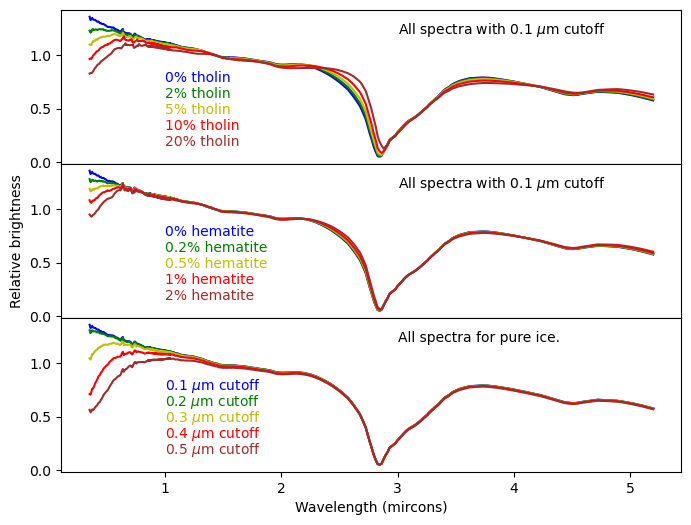

In [25]:
fig = plt.figure(figsize=(8,6))
gs = fig.add_gridspec(3, hspace=0)
#plt.rcParams.update(plt.rcParamsDefault)
axs = gs.subplots(sharex=True)
plt.style.use('default')
cols=['b','g','y','r','brown']
labs1=['0% tholin','2% tholin','5% tholin','10% tholin','20% tholin']
labs2=['0% hematite','0.2% hematite','0.5% hematite','1% hematite','2% hematite']
labs3=['0.1 $\mu$m cutoff','0.2 $\mu$m cutoff','0.3 $\mu$m cutoff','0.4 $\mu$m cutoff','0.5 $\mu$m cutoff']
foo=(wavex>1) & (wavex<2)
for i in range(5):
    axs[0].plot(wavex, specs1[i,:]/np.median(specs1[i,foo]), color=cols[i])
    #axs[0].plot(wavex, specs1p[i,:]/np.median(specs1p[i,foo]), ':',color=cols[i])
    axs[0].text(1,.75-.15*i,labs1[i], color=cols[i])
for i in range(5):
    axs[1].plot(wavex, specs2[i,:]/np.median(specs2[i,foo]), color=cols[i])
    axs[1].text(1,.75-.15*i,labs2[i], color=cols[i])
for i in range(5):
    axs[2].plot(wavex, specs3[i,:]/np.median(specs2[i,foo]), color=cols[i])
    axs[2].text(1,.75-.15*i,labs3[i], color=cols[i])
plt.xlabel('Wavelength (mircons)')
axs[0].text(3,1.2,'All spectra with 0.1 $\mu$m cutoff')
axs[1].text(3,1.2,'All spectra with 0.1 $\mu$m cutoff')
axs[2].text(3,1.2,'All spectra for pure ice.')

#axs[0].set_ylabel('Relative brightness')
axs[1].set_ylabel('Relative brightness')
plt.savefig('miespec_examples_071525.pdf', bbox_inches='tight')

plt.show()